<a href="https://colab.research.google.com/github/hydraadra112/v-net-classifier/blob/dev-model/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Automated DR Classification with PyTorch!**

## Dataset Images

In this section, we are going to:

- Check if dataset in local exists
- Create a method that will plot a random image from our dataset
- Check the properties of our image such as the placing of shapes, preferably change it to [C, H, W]
- Perform basic data augmentation
- Create a `dataset`, and `DataLoader` objects

In [1]:
# Install the required libraries
!pip install torch==2.2.0 torchvision==0.17.0 torchmetrics==1.6.1
!pip install opencv-python==4.9.0.80 numpy==1.26.4 matplotlib==3.10.0
!pip install jupyter==1.1.1 ipykernel==6.29.5 pathlib==1.0.1
!pip install kagglehub

import torch
print(f"Torch version: {torch.__version__}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 75.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 46.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 54.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 28.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 37.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

In [2]:
import os
from pathlib import Path
import kagglehub
import shutil

# Define target directory
target_dir = Path('./dataset/')

# Check if dataset already exists
if not target_dir.exists() or not any(target_dir.iterdir()):
    print("Dataset not found. Downloading...")

    # Download dataset
    path = kagglehub.dataset_download("sovitrath/diabetic-retinopathy-224x224-2019-data")

    # Ensure target directory exists
    os.makedirs(target_dir, exist_ok=True)

    # Move dataset contents
    for item in os.listdir(path):
        shutil.move(os.path.join(path, item), target_dir)

    print("Dataset downloaded and moved to:", target_dir)
else:
    print("Dataset already exists. Skipping download.")

# Check if a specific dataset subfolder exists
dataset_path = target_dir / 'colored_images/'

if dataset_path.exists():
    print('Dataset exists at:', dataset_path)
else:
    print('Dataset does not exist at:', dataset_path)

Dataset already exists. Skipping download.
Dataset exists at: dataset\colored_images


In [7]:
import random
import matplotlib.image as mpimg

# Create a method that will plot a random image from our dataset
def plot_random_image(dataset_path: Path = Path(r'./dataset/colored_images/')) -> None:
    """
    Plots a random image from our dataset

    Args:
        dataset_path (Path): The directory of the dataset with subfolders as its classification

    Returns:
        None
    """

    # Get random label
    labels = next(os.walk(dataset_path))[1]
    random_index = random.randint(1, len(labels))
    random_label = labels[random_index]

    label_dir = dataset_path / random_label

    # Get random image
    random_image = label_dir / random.choice(os.listdir(label_dir))

    # Plot the extracted image
    plt.figure()

    img = mpimg.imread(random_image)
    imgplot = plt.imshow(img)

    plt.title(f'Grade: {random_label} - DR')
    plt.show(imgplot)

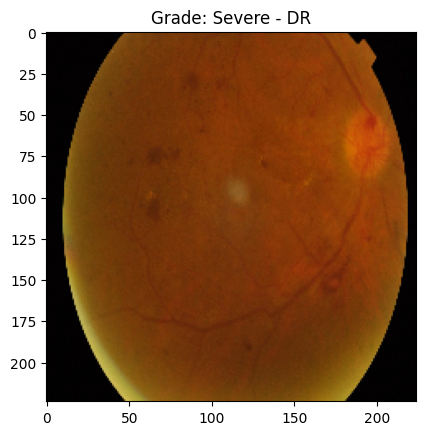

In [8]:
plot_random_image()

In [9]:
# Check the properties of our image, change shape to [C, H, W]

from PIL import Image
import torchvision
from torchvision.transforms import v2

# Get a random image
labels = next(os.walk(dataset_path))[1]
random_index = random.randint(1, len(labels))
random_label = labels[random_index]

label_dir = dataset_path / random_label

random_image_path = label_dir / random.choice(os.listdir(label_dir))

img = Image.open(random_image_path)

transform = v2.Compose([
    v2.PILToTensor(),
    v2.Resize((224,224)),
    v2.ConvertImageDtype(dtype=torch.float32),
    v2.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])
])

img_tensor = transform(img)

In [10]:
type(img_tensor), img_tensor.shape, img_tensor

(torch.Tensor,
 torch.Size([3, 224, 224]),
 tensor([[[-0.9922, -0.9922, -1.0000,  ..., -0.9843, -0.9765, -0.9922],
          [-0.9922, -0.9922, -1.0000,  ..., -0.9843, -0.9843, -0.9922],
          [-0.9922, -0.9922, -0.9922,  ..., -0.9843, -0.9765, -0.9922],
          ...,
          [-0.9608, -0.9843, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]],
 
         [[-0.9922, -0.9922, -1.0000,  ..., -1.0000, -0.9922, -1.0000],
          [-0.9922, -0.9922, -1.0000,  ..., -1.0000, -0.9922, -1.0000],
          [-0.9922, -0.9922, -0.9922,  ..., -1.0000, -0.9843, -1.0000],
          ...,
          [-0.9608, -0.9843, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]],
 
         [[-0.9922, -0.9922, -1.0000,  ..., -0.9922, -1.0

In [11]:
import numpy as np

class MedianFilter:
    def __init__(self, kernel_size: int = 3):
        if not isinstance(kernel_size, int) or kernel_size <= 0:
            raise ValueError("Kernel size must be a positive integer.")
        self.kernel_size = kernel_size

    def __call__(self, img):
        img = np.array(img)
        median_img = cv2.medianBlur(img, ksize=self.kernel_size)
        return Image.fromarray(median_img)

class CLAHE:
  def __init__(self, clipLimit=2.0, tileGridSize=(8,8)):
    self.clipLimit = clipLimit
    self.tileGridSize = tileGridSize

  def __call__(self, img):
    img_np = np.array(img)[:, :, ::-1]  # Convert RGB to BGR for OpenCV

    # Convert BGR to LAB using OpenCV
    lab = cv2.cvtColor(img_np, cv2.COLOR_BGR2Lab)

    L, A, B = cv2.split(lab)

    clahe = cv2.createCLAHE(clipLimit=self.clipLimit, tileGridSize=self.tileGridSize)
    L_clahe = clahe.apply(L)

    lab_clahe = cv2.merge((L_clahe, A, B))

    # Convert LAB back to BGR
    bgr_clahe = cv2.cvtColor(lab_clahe, cv2.COLOR_Lab2BGR)

    # Convert BGR to RGB
    rgb_clahe = bgr_clahe[:, :, ::-1]

    # Convert NumPy array back to PIL Image
    img_clahe = Image.fromarray(rgb_clahe)

    return img_clahe

class GammaCorrection:
    def __init__(self, gamma=1.5, gain=1.0):
        self.gamma = gamma
        self.gain = gain

    def __call__(self, img):
        return F.adjust_gamma(img, gamma=self.gamma, gain=self.gain)

In [12]:
# Create `dataset` object
from torchvision import datasets
from torch.utils.data import random_split
import torchvision.transforms.functional as F

# Create transformation pipelines AND for data augmentation
train_transform = v2.Compose([
    v2.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0)),
    v2.ColorJitter(brightness=0.1, contrast=0.2, saturation=0.2, hue=0.02),
    MedianFilter(3),
    CLAHE(),
    GammaCorrection(),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomRotation(degrees=5),
    v2.ToTensor(),
    v2.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

test_transform = v2.Compose([
    v2.Resize((224,224)),
    v2.ToTensor(),
    v2.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

full_dataset = datasets.ImageFolder(root=dataset_path)

idx_labels = full_dataset.class_to_idx

# Define train and test size
train_size = int(0.8 * len(full_dataset))
test_size = int(len(full_dataset) - train_size)

# splitting the dataset
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

# applying different transforms
train_dataset.dataset.transform = train_transform
test_dataset.dataset.transform = test_transform


c:\Users\admin\Desktop\Classes\2nd sem\Intelligent Systems\HF Spaces\Diabetic_Retinopathy_Automated_Grading\.venv\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


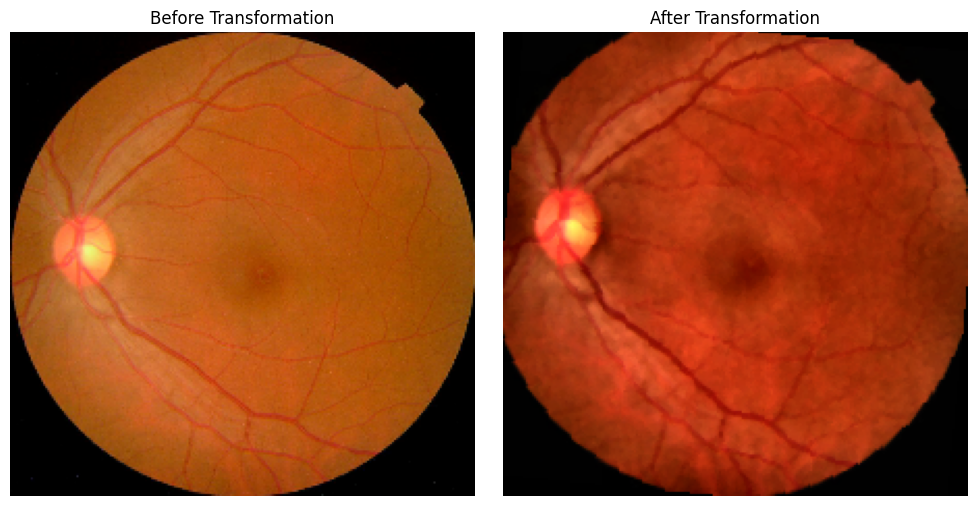

In [13]:
from torchvision.transforms.functional import to_pil_image
# Plot sample image that goes through the train transform
def plot_before_after(tensor_img, transform_pipeline):
    if not isinstance(tensor_img, torch.Tensor):
        raise TypeError("Input image should be a torch.Tensor")

    unnormalize = v2.Normalize(mean=[-1, -1, -1], std=[2, 2, 2])
    img_pil = to_pil_image(unnormalize(tensor_img))

    transformed_img = transform_pipeline(img_pil)

    if isinstance(transformed_img, torch.Tensor):
        transformed_img = to_pil_image(unnormalize(transformed_img))

    # Plot both images
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(img_pil)
    axes[0].set_title('Before Transformation')
    axes[0].axis('off')

    axes[1].imshow(transformed_img)
    axes[1].set_title('After Transformation')
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()

plot_before_after(img_tensor, train_transform)

In [14]:
# See how many images we are dealing with
print(f'Training dataset: {len(train_dataset)}')
print(f'Testing dataset: {len(test_dataset)}')

Training dataset: 2929
Testing dataset: 733


> Before creating a `dataset` object, make sure you have the structure for your dataset:

```
├── train
│   ├── class1
|      ├── 1.jpg
│      ├── 2.jpg
│   ├── class2
|      ├── 1.jpg
│      ├── 2.jpg
├── valid
│   ├── class1
|      ├── 1.jpg
│      ├── 2.jpg
│   ├── class2
|      ├── 1.jpg
│      ├── 2.jpg
```

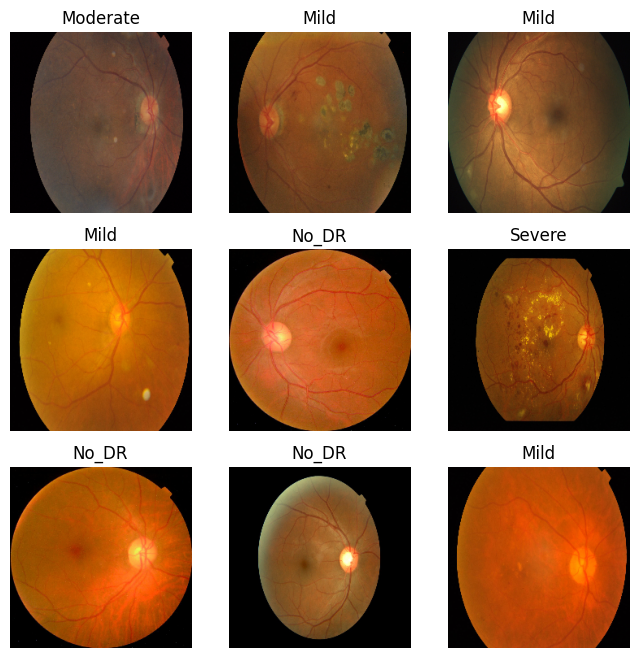

In [15]:
# Visualizing our data

def unnormalize(img, mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)):
    img = img.clone()  # Avoid modifying original tensor
    for t, m, s in zip(img, mean, std):
        t.mul_(s).add_(m)  # reverse normalization: (img * std) + mean
    return img

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    img = unnormalize(img) # Unnormalized temporarily for visualization
    figure.add_subplot(rows, cols, i)
    plt.title(list(idx_labels.keys())[list(idx_labels.values()).index(label)])
    plt.axis("off")
    plt.imshow(img.permute(1, 2, 0))
plt.show()

In [16]:
# Create `DataLoader` object

from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)

In [31]:
# See dataloader batch data
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

# Get single image and label, check their shapes
single_img = train_features[0]
label = train_labels[0]

print(f'Single Image: {single_img.shape}')
print(f'Label: {label}, {type(label)}')

Feature batch shape: torch.Size([64, 3, 224, 224])
Labels batch shape: torch.Size([64])
Single Image: torch.Size([3, 224, 224])
Label: 2, <class 'torch.Tensor'>


## Training

In this section, we are going to:

- Create our Torch class parameters
- Create a method for training and testing our models
- Use visualizations to assess the model

In [32]:
# Creating NN Torch class
import torch.nn.init as init

class DR_Classifier(nn.Module):
    def __init__(self, input_shape: int, output_shape: int, hidden_units: int = 20):
        super().__init__()

        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      padding=1,
                      ),
            nn.BatchNorm2d(hidden_units),
            nn.LeakyReLU(0.1),
            nn.Conv2d(hidden_units,
                      hidden_units,
                      3,
                      1,
                      1), # These are already in default value, except kernel_size
            nn.BatchNorm2d(hidden_units),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.2)
        )

        self.block2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units * 2, kernel_size=3, padding=1),
            nn.BatchNorm2d(hidden_units * 2),
            nn.LeakyReLU(0.1),
            nn.Conv2d(hidden_units * 2, hidden_units * 2, kernel_size=3, padding=1),
            nn.BatchNorm2d(hidden_units * 2),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.3)
        )

        self.block3 = nn.Sequential(
            nn.Conv2d(hidden_units * 2, hidden_units * 4, kernel_size=3, padding=1),
            nn.BatchNorm2d(hidden_units * 4),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.3)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(hidden_units * 4 * 28 * 28, 512),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.4),
            nn.Linear(512, output_shape)
        )

    def _initialize_weights(self):
      for m in self.modules():
          if isinstance(m, nn.Conv2d):
              init.kaiming_normal_(m.weight, nonlinearity='leaky_relu')
              if m.bias is not None:
                  init.constant_(m.bias, 0)
          elif isinstance(m, nn.Linear):
              init.kaiming_normal_(m.weight, nonlinearity='leaky_relu')
              if m.bias is not None:
                  init.constant_(m.bias, 0)
          elif isinstance(m, nn.BatchNorm2d):
              init.constant_(m.weight, 1)
              init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.classifier(x)
        return x

model_1 = DR_Classifier(input_shape=3, output_shape=len(idx_labels), hidden_units=25)
model_1, model_1.parameters

(DR_Classifier(
   (block1): Sequential(
     (0): Conv2d(3, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (1): BatchNorm2d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (2): LeakyReLU(negative_slope=0.1)
     (3): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (4): BatchNorm2d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (5): LeakyReLU(negative_slope=0.1)
     (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (7): Dropout(p=0.2, inplace=False)
   )
   (block2): Sequential(
     (0): Conv2d(25, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (1): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (2): LeakyReLU(negative_slope=0.1)
     (3): Conv2d(50, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (4): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (5): LeakyReLU(n

In [33]:
class DR_Classifierv2(nn.Module):
    def __init__(self,  output_shape: int, input_shape: int = 3, hidden_units: int = 64):
        super().__init__()

        self.block1 = nn.Sequential(
            nn.Conv2d(input_shape, hidden_units, kernel_size=3, padding='same'),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(hidden_units),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding='same'),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(hidden_units),
            nn.MaxPool2d(2),
            nn.Dropout(0.3)
        )

        self.block2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units * 2, kernel_size=3, padding='same'),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(hidden_units * 2),
            nn.Conv2d(hidden_units * 2, hidden_units * 2, kernel_size=3, padding='same'),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(hidden_units * 2),
            nn.MaxPool2d(2),
            nn.Dropout(0.4)
        )

        self.block3 = nn.Sequential(
            nn.Conv2d(hidden_units * 2, hidden_units * 4, kernel_size=3, padding='same'),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(hidden_units * 4),
            nn.Conv2d(hidden_units * 4, hidden_units * 4, kernel_size=3, padding='same'),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(hidden_units * 4),
            nn.MaxPool2d(2),
            nn.Dropout(0.4)
        )

        self.block4 = nn.Sequential(
            nn.Conv2d(hidden_units * 4, hidden_units * 8, kernel_size=3, padding='same'),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(hidden_units * 8),
            nn.Conv2d(hidden_units  * 8, hidden_units  * 8, kernel_size=3, padding='same'),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(hidden_units * 8),
            nn.MaxPool2d(2),
            nn.Dropout(0.5)
        )

        self.adaptiveAvgPool = nn.AdaptiveAvgPool2d(1)

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(hidden_units * 8, 512),
            nn.LeakyReLU(0.1),
            nn.BatchNorm1d(512),
            nn.Dropout(0.5),
            nn.Linear(512, output_shape)
        )

    def forward(self, x: torch.Tensor):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.adaptiveAvgPool(x)
        x = self.classifier(x)
        return x

model_2 = DR_Classifierv2(input_shape=3, output_shape=len(idx_labels), hidden_units=64)
model_2, model_2.parameters()

(DR_Classifierv2(
   (block1): Sequential(
     (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
     (1): LeakyReLU(negative_slope=0.1)
     (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
     (4): LeakyReLU(negative_slope=0.1)
     (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (7): Dropout(p=0.3, inplace=False)
   )
   (block2): Sequential(
     (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
     (1): LeakyReLU(negative_slope=0.1)
     (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
     (4): LeakyReLU(negative_slope=0.1)
     (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_ru

In [34]:
# Create a train and testing method
from typing import Callable, Tuple, List

def train_step(model: nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn: Callable[[torch.Tensor, torch.Tensor], torch.Tensor],
               device: torch.device
               ) -> Tuple[float, float]:
    model.to(device)
    model.train()

    total_loss, total_acc = 0.0, 0.0
    total_samples = 0

    for batch, (X, y) in enumerate(data_loader):
        X, y = X.to(device), y.to(device)
        batch_size = X.size(0)
        total_samples += batch_size

        # Forward pass
        y_pred = model(X)

        # Compute loss and accuracy
        loss = loss_fn(y_pred, y)
        acc = accuracy_fn(y_pred.argmax(dim=1), y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate weighted loss and accuracy
        total_loss += loss.item() * batch_size
        total_acc += acc.item() * batch_size

        print(f"[Train] Batch {batch + 1}/{len(data_loader)} | Loss: {loss.item():.5f} | Acc: {acc.item():.2f}% | Samples: {batch_size}")

    # Weighted averages
    avg_loss = total_loss / total_samples
    avg_acc = total_acc / total_samples
    print(f"[Train Summary] Avg Loss: {avg_loss:.5f} | Avg Acc: {avg_acc:.2f}%\n")

    return avg_loss, avg_acc


def test_step(model: nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: nn.Module,
              accuracy_fn: Callable[[torch.Tensor, torch.Tensor], torch.Tensor],
              device: torch.device
              ) -> Tuple[float, float]:
    model.to(device)
    model.eval()

    total_loss, total_acc = 0.0, 0.0
    total_samples = 0

    with torch.inference_mode():
        for batch, (X, y) in enumerate(data_loader):
            X, y = X.to(device), y.to(device)
            batch_size = X.size(0)
            total_samples += batch_size

            # Forward pass
            y_pred = model(X)

            # Compute loss and accuracy
            loss = loss_fn(y_pred, y)
            acc = accuracy_fn(y_pred.argmax(dim=1), y)

            total_loss += loss.item() * batch_size
            total_acc += acc.item() * batch_size

            print(f"[Test] Batch {batch + 1}/{len(data_loader)} | Loss: {loss.item():.5f} | Acc: {acc.item():.2f}% | Samples: {batch_size}")

    avg_loss = total_loss / total_samples
    avg_acc = total_acc / total_samples
    print(f"[Test Summary] Avg Loss: {avg_loss:.5f} | Avg Acc: {avg_acc:.2f}%\n")

    return avg_loss, avg_acc

In [35]:
def evaluate_model(model: nn.Module, train_loss, test_loss, train_acc, test_acc, num_epochs) -> None:
  '''
  Evaluates the PyTorch model by plotting the loss, and compares the accuracy

  Args:
    model (nn.Module): A PyTorch neural network module
    train_loss: A list of the train losses
    test_loss: A list of the test losses
    train_acc: A list of the train accuracies
    test_acc: A list of the test accuracies
    num_epochs: Number of epochs the model is trained
  '''

  epochs = range(1, num_epochs + 1)
  fig, ax = plt.subplots(1, 2, figsize=(12, 5))

  # Loss curves
  ax[0].plot(epochs, train_loss, label='Train Loss')
  ax[0].plot(epochs, test_loss, label='Test Loss')
  ax[0].set_title('Loss Curves')
  ax[0].set_xlabel('Epochs')
  ax[0].set_ylabel('Loss')
  ax[0].legend()

  # Accuracy
  ax[1].plot(epochs, train_acc, label='Train Acc')
  ax[1].plot(epochs, test_acc, label='Test Acc')
  ax[1].set_title('Accuracy Plot')
  ax[1].set_xlabel('Epochs')
  ax[1].set_ylabel('Accuracy')
  ax[1].legend()

  plt.tight_layout()
  plt.show()

In [36]:
def train_evaluate_model(MODEL: nn.Module,
                        train_data_loader: torch.utils.data.DataLoader,
                        test_data_loader: torch.utils.data.DataLoader,
                        loss_fn: nn.Module,
                        optimizer: torch.optim.Optimizer,
                        accuracy_fn: Callable[[torch.Tensor, torch.Tensor], torch.Tensor],
                        n_epochs: int
                         ):
    
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    accuracy_fn = accuracy_fn.to(DEVICE)

    train_loss_list, train_acc_list = [], []
    test_loss_list, test_acc_list = [], []

    for epoch in range(n_epochs):
        print(f'Epoch: {epoch + 1}\n{"-" * 40}')

        train_loss, train_acc = train_step(
            model=MODEL,
            data_loader=train_data_loader,
            loss_fn=loss_fn,
            optimizer=optimizer,
            accuracy_fn=accuracy_fn,
            device=DEVICE
        )

        test_loss, test_acc = test_step(
            model=MODEL,
            data_loader=test_data_loader,
            loss_fn=loss_fn,
            accuracy_fn=accuracy_fn,
            device=DEVICE
        )

        train_loss_list.append(train_loss)
        train_acc_list.append(train_acc)
        test_loss_list.append(test_loss)
        test_acc_list.append(test_acc)

        print(f'{"-" * 40}\n\n')
        
        
    evaluate_model(MODEL, train_loss_list, test_loss_list, train_acc_list, test_acc_list)


In [ ]:
# DR Classifier - Model 1
from torchmetrics.classification import Accuracy
import torch.optim as optim

""" loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=model_1.parameters(),
                             lr=0.00001)
acc_fn = Accuracy(task="multiclass", num_classes=len(idx_labels))

train_evaluate_model(model_1,
                     train_data_loader=train_dataloader,
                     test_data_loader=test_dataloader,
                     loss_fn=loss_fn,
                     accuracy_fn=acc_fn,
                     optimizer=optimizer,
                     n_epochs=30
                     )
 """


TypeError: train_evaluate_model() missing 1 required positional argument: 'optimizer'

In [39]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=model_2.parameters(),
                             lr=0.0001)
acc_fn = Accuracy(task="multiclass", num_classes=len(idx_labels))

train_evaluate_model(model_2,
                     train_data_loader=train_dataloader,
                     test_data_loader=test_dataloader,
                     loss_fn=loss_fn,
                     accuracy_fn=acc_fn,
                     optimizer=optimizer,
                     n_epochs=30
                     )

Epoch: 1
----------------------------------------


KeyboardInterrupt: 

## Saving and Loading

In this section, we are going to:

- Save the trained PyTorch model
- Load the PyTorch model
- Perform a basic prediction on the loaded model

In [26]:
# Saving the trained PyTorch model
MODEL_PATH = Path(r'./dataset')

# Create model save path
MODEL_NAME = "model_2_1.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")

torch.save(obj=model_2.state_dict(), # only saving the state_dict() only saves the learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: dataset/model_2_1.pth


In [ ]:
# Loading the PyTorch model!
loaded_model = DR_Classifier(input_shape=3,
                                hidden_units=10, # try changing this to 128 and seeing what happens
                                output_shape=len(idx_labels))

# Load in the saved state_dict()
loaded_model.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

# Send model to DEVICE
loaded_model = loaded_model.to(DEVICE)